In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
import pandas as pd
import numpy as np
import csv

对于图表的大小，可以用下一个单元格的魔术命令就可以开启一个图表的交互窗口，比较自由。

另一个方法就是调用plt的rcParams方法直接调整图表尺寸

In [2]:
#%matplotlib notebook

下一个单元格为导入数据

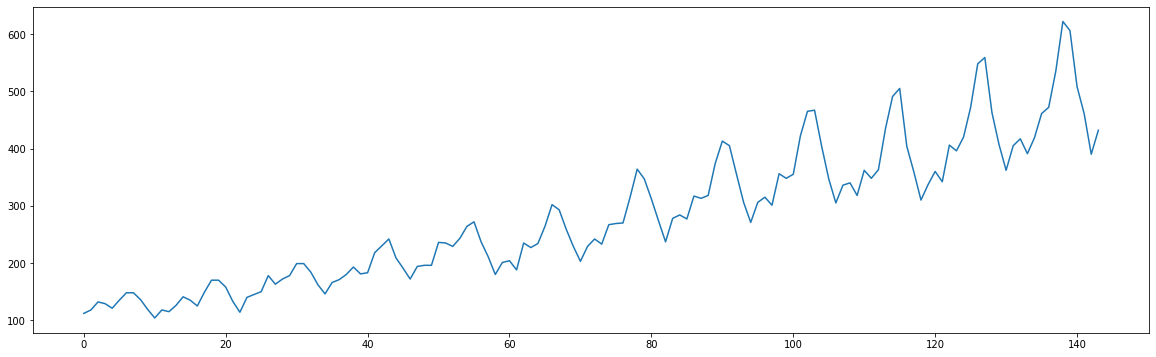

In [3]:
df1 = pd.read_csv("airline-passengers.csv")
data = pd.DataFrame(df1[["Month","Passengers"]], columns = ["Month","Passengers"])
data.columns = ["month", "aav"]
plt.rcParams["figure.figsize"] = (20.0, 6.0)
plt.plot(list(range(len(data))), list(data.aav))

下一个单元格是在进行预测训练，使用的预测模型为季节性乘法模型。公式为:

$$l_t=\alpha\frac{y_t}{s_{t-m}}+(1-\alpha)(l_{t-1}+b_{t-1})$$

$$b_t=\beta(l_t-l_{t-1})+(1-\beta)b_{t-1}$$

$$s_t=\gamma\frac{y_t}{l_{t-1}+b_{t-1}}+(1-\gamma)s_{t-m}$$

$$f_t=(l_t+b_t)s_{t+1-m(k+1)}$$

其中$f_t$为训练中一步之后的预测值，$m$为周期长度；$l_t$为基础值，$\alpha$为其平滑参数；$b_t$为增长率，$\beta$为其平滑参数；$s_t$为周期规律，$\gamma$为其平滑参数。周期规律为各个数据点相对于周期均值的百分比。

我从原数据中拿掉了最后十二个数据点作为测试数据，剩下的全部作为训练数据。图中红线为在训练中的预测值，蓝线为原始数据。


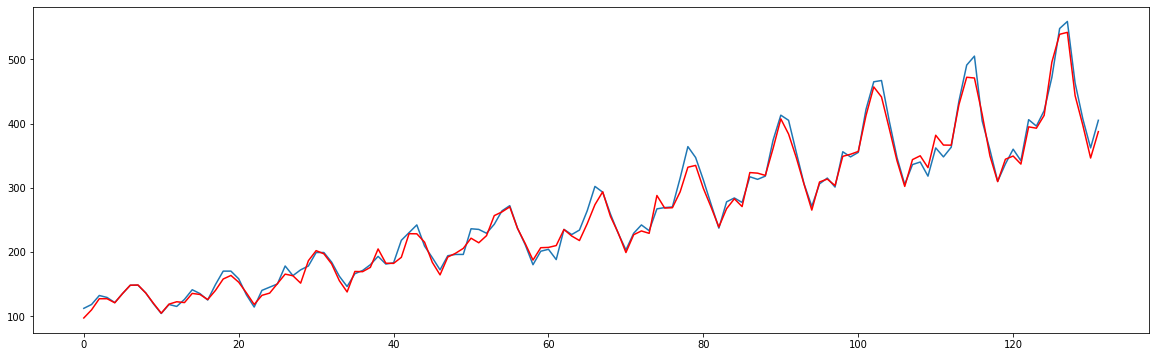

In [4]:
actual = pd.DataFrame(data.iloc[:-12].reset_index(drop=True))
actual.columns = ["month", "y_t"]
actual["l_t"] = None
actual["b_t"] = None
actual["s_t"] = None
actual["f_t"] = None
s = [0.88, 0.93, 1.04, 1.02, 0.96, 1.07, 1.17, 1.17, 1.07, 0.94, 0.82, 0.93]
l = [110]
b = [0.23]
alpha = 0.432
beta = 0.008
gama = 0.5772

for i in range(len(actual)):
    lt = alpha*(actual.iloc[i, 1]/s[i])+(1-alpha)*(l[i]+b[i])
    bt = beta*(lt-l[i])+(1-beta)*b[i]
    st = gama*(actual.iloc[i, 1]/(l[i]+b[i]))+(1-gama)*s[i]
    ft = (l[i]+b[i])*s[i]
    actual.iloc[i, 2] = lt
    actual.iloc[i, 3] = bt
    actual.iloc[i, 4] = st
    actual.iloc[i, 5] = ft
    l.append(lt)
    b.append(bt)
    s.append(st)
plt.plot(list(range(len(actual))), list(actual.y_t))
plt.plot(list(range(len(actual))), list(actual.f_t), color="red")


下一个单元格是再用上一个单元格的结果做预测。在这里，我用的是最后十二个数据点作测试。公式为：

$$\widehat{y}_{t+h|t}=(l_t+hb_t)s_{t+h-m(k+1)}$$

其中$\widehat{y}_{t+h|t}$为$h$步之后的预测值，$h$为离最后一个训练数据点的步数，$l_t$为训练出来的基础值，$b_t$为训练出来的斜率，$s_{t+h-m(k+1)}$为当前预测点在周期规律中的值。图中蓝线为原始数据，红线为预测数据。

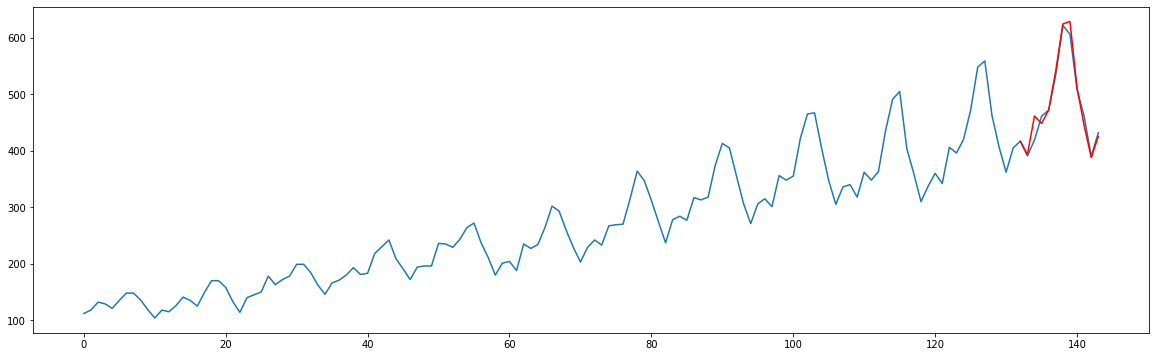

In [5]:
x = list(range(len(data)))
y = [(l[-1]+(i+1)*b[-1])*s[-12+i] for i in range(12)]
plt.plot(list(range(len(data))), list(data.aav))
plt.plot(x, [None for i in range(len(actual))]+y, color="red")

下面的单元格主要使用了三种公式展示了预测值的百分之九十五的预测区间。
残差的标准差：数值含义类似于残差的平均数

公式：

$$\sigma=\sqrt{\frac{\sum{{(y_t-f_t)}^2}}{n-2}}$$

其中$y_t$为实际值，$f_t$为预测值，$n$为残差个数。

覆盖度乘积（percentage coverage multiplier）：统计学中固定的参数

百分之九十五的覆盖度使用的覆盖度乘积为1.96。--[参考链接中的表3.1](https://otexts.com/fpp2/prediction-intervals.html)

第一种预测区间的算法：Naive forcast

最简单的算法，承袭于朴素预测模型，假设了预测值与最后一个观察值一样，区间宽度中等。

公式：

$$interval=f_t\pm{c*\sigma*\sqrt{h}}$$

其中$c$是覆盖度乘积，$\sigma$是残差的标准差，$h$是离最后一个测试数据点的步数。

图中，蓝色为原始数据，红色为预测数据，绿色为预测数据的预测区间。

plt.fill_between()填色函数: 第一个参数为x轴数组，第二第三个参数分别为上限和下限的y轴数组，alpha参数为区间填色透明度。

10.971484400441039


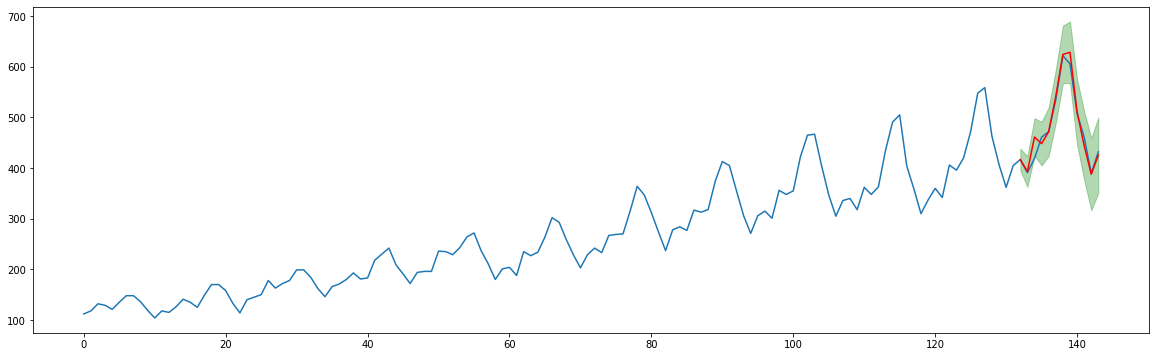

In [6]:
residuals = []
for i, element in actual.iterrows():
    residuals.append(abs(element["y_t"]-element["f_t"]))
std_res = np.sqrt(sum([pow(i, 2) for i in residuals])/(len(residuals)-2))
print(std_res)
upper = [y[i] + 1.96 * std_res * np.sqrt(i + 1) for i in range(len(y))]
lower = [y[i] - 1.96 * std_res * np.sqrt(i + 1) for i in range(len(y))]
plt.plot(list(range(len(data))), list(data.aav))
plt.plot(x, [None for i in range(len(actual))]+y, color="red")
plt.fill_between(x[-12:], upper, lower, color="green", alpha=0.3)#百分之九十五的置信区间

下面的单元格主要是把预测结果与这个方法下的预测区间单独提取出来做效果放大图

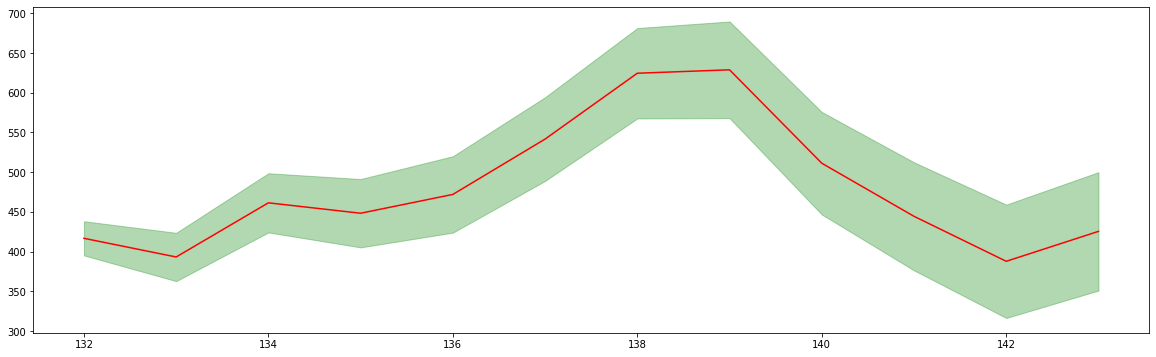

In [7]:
plt.plot(x, [None for i in range(len(actual))]+y, color="red")
plt.fill_between(x[-12:], upper, lower, color="green", alpha=0.3)

第二种预测区间的算法：Seasonal naive forcast

承袭于季节性朴素预测模型，假设预测周期与观察到的周期一致，区间宽度最小，带有季节的特征。

公式：

$$interval=f_t\pm{c*\sigma*\sqrt{\lfloor\frac{h-1}{m}\rfloor+1}}$$

其中$c$是覆盖度乘积，$\sigma$是残差的标准差，$h$是离最后一个测试数据点的步数，$m$是周期长度。

图中，蓝色为原始数据，红色为预测数据，绿色为预测数据的预测区间。填色函数中的alpha参数为区间填色透明度。

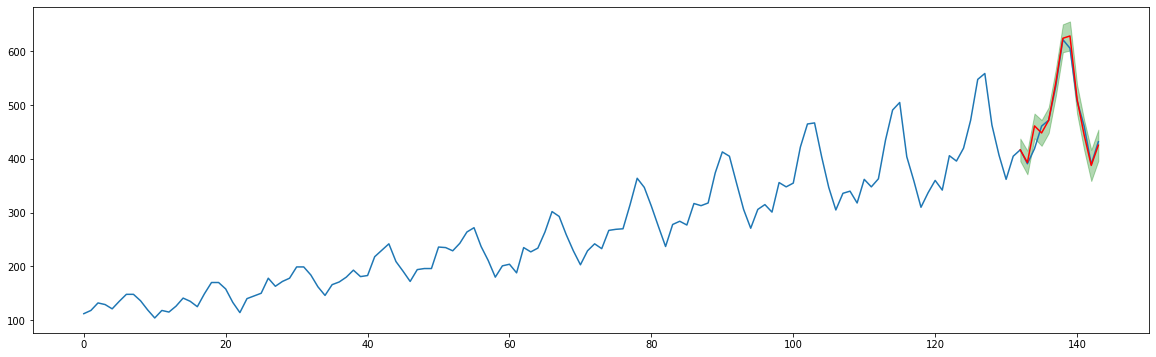

In [8]:
upper = [y[i] + 1.96 * std_res * np.sqrt(i/12 + 1)//1 for i in range(len(y))]
lower = [y[i] - 1.96 * std_res * np.sqrt(i/12 + 1)//1 for i in range(len(y))]
plt.plot(list(range(len(data))), list(data.aav))
plt.plot(x, [None for i in range(len(actual))]+y, color="red")
plt.fill_between(x[-12:], upper, lower, color="green", alpha=0.3)

下面的单元格主要是把预测结果与这个方法下的预测区间单独提取出来做效果放大图

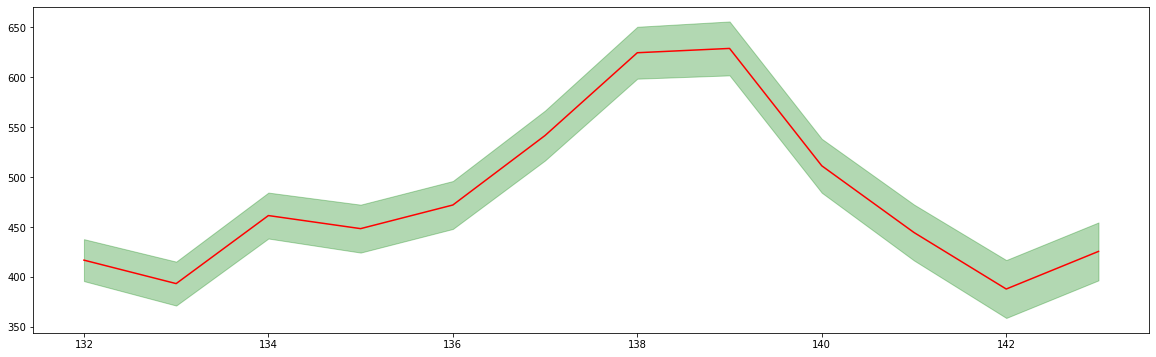

In [9]:
plt.plot(x, [None for i in range(len(actual))]+y, color="red")
plt.fill_between(x[-12:], upper, lower, color="green", alpha=0.3)

第三种预测区间的算法：Drift forcast

承袭于季节性飘逸预测模型，假设了预测斜率与最后一次观测到的斜率一致，区间宽度在训练数据数远大于预测步数的情况下与第一种预测区间的算法没什么区别，如果训练数据量较少的话，此方法下得到的预测区间就会比较大。

公式：

$$interval=f_t\pm{c*\sigma*\sqrt{h(1+\frac{h}{T})}}$$

其中$c$是覆盖度乘积，$\sigma$是残差的标准差，$h$是离最后一个测试数据点的步数，$T$是训练数据长度。

图中，蓝色为原始数据，红色为预测数据，绿色为预测数据的预测区间。填色函数中的alpha参数为区间填色透明度。

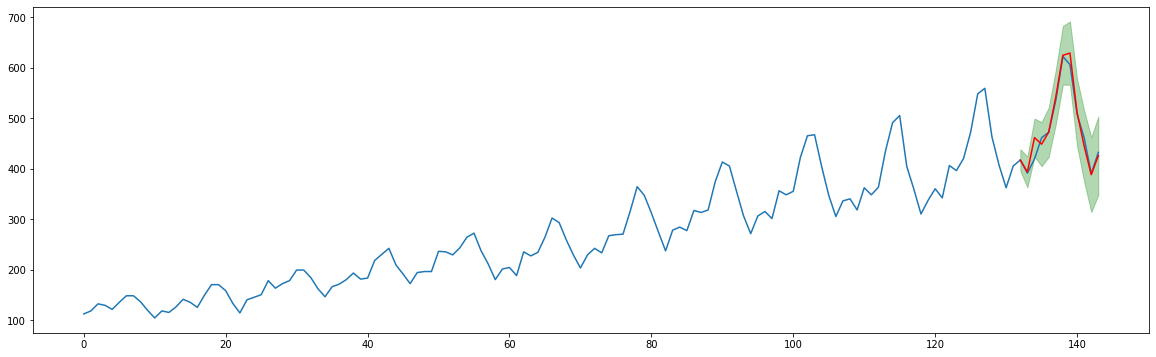

In [10]:
upper = [y[i] + 1.96 * std_res * np.sqrt((i+1)*(1+(i+1)/132)) for i in range(len(y))]
lower = [y[i] - 1.96 * std_res * np.sqrt((i+1)*(1+(i+1)/132)) for i in range(len(y))]
plt.plot(list(range(len(data))), list(data.aav))
plt.plot(x, [None for i in range(len(actual))]+y, color="red")
plt.fill_between(x[-12:], upper, lower, color="green", alpha=0.3)

下面的单元格主要是把预测结果与这个方法下的预测区间单独提取出来做效果放大图

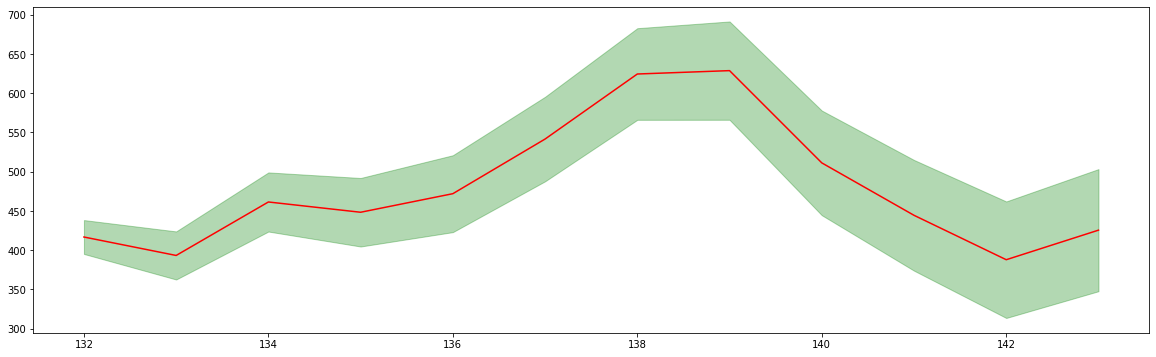

In [11]:
plt.plot(x, [None for i in range(len(actual))]+y, color="red")
plt.fill_between(x[-12:], upper, lower, color="green", alpha=0.3)